In [1]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [2]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl

Please replace `YOUR_API_KEY` with the assigned API key string. Note that it should be without quotes.

For example, if the assigned API Key is `abcd1234`, you can do the following

```python
%env ROCKFISH_API_KEY=abcd1234
conn = rf.Connection.from_env()
```

If you do not have API Key, please reach out to support@rockfish.ai.


In [3]:
%env ROCKFISH_API_KEY=YOUR_API_KEY
conn = rf.Connection.from_env()

In [4]:
# download our example of timeseries data: pcap.csv
!wget --no-clobber https://docs.rockfish.ai/tutorials/pcap.csv

--2024-12-12 18:56:59--  https://docs.rockfish.ai/tutorials/pcap.csv
Resolving docs.rockfish.ai (docs.rockfish.ai)... 2600:9000:249b:d600:3:1cb5:3480:93a1, 2600:9000:249b:5800:3:1cb5:3480:93a1, 2600:9000:249b:ea00:3:1cb5:3480:93a1, ...
Connecting to docs.rockfish.ai (docs.rockfish.ai)|2600:9000:249b:d600:3:1cb5:3480:93a1|:443... connected.


I0000 00:00:1734058619.616208 8428882 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


HTTP request sent, awaiting response... 200 OK
Length: 7043 (6.9K) [text/csv]
Saving to: ‘pcap.csv’

pcap.csv            100%[===================>]   6.88K  --.-KB/s    in 0s      

2024-12-12 18:57:00 (517 MB/s) - ‘pcap.csv’ saved [7043/7043]



In [5]:
dataset = rf.Dataset.from_csv("DC pcap", "pcap.csv")
dataset.to_pandas()

,srcip,dstip,srcport,dstport,proto,timestamp,pkt_len
0,244.3.253.224,244.3.160.239,3396,80,6,2009-12-17 16:27:36.075494,40
1,41.177.26.91,68.157.168.194,80,65003,6,2009-12-17 16:27:36.075515,1500
2,41.177.26.91,68.157.168.194,80,65003,6,2009-12-17 16:27:36.075519,940
3,41.177.26.91,68.157.168.194,80,65003,6,2009-12-17 16:27:36.075553,1500
4,41.177.26.91,68.157.168.194,80,65003,6,2009-12-17 16:27:36.075603,1500
...,...,...,...,...,...,...,...
95,68.157.168.194,41.177.26.91,45615,80,6,2009-12-17 16:27:36.099423,60
96,41.177.26.91,68.157.168.194,80,45615,6,2009-12-17 16:27:36.099891,64
97,41.177.3.203,41.177.3.224,58381,1791,6,2009-12-17 16:27:36.100508,40
98,244.3.41.84,244.3.31.67,2626,1592,6,2009-12-17 16:27:36.105025,237


In [6]:
config = {
    "encoder": {
        "timestamp": {"field": "timestamp"},
        "metadata": [
            {"field": "srcip", "type": "categorical"},
            {"field": "dstip", "type": "categorical"},
            {"field": "srcport", "type": "categorical"},
            {"field": "dstport", "type": "categorical"},
            {"field": "proto", "type": "categorical"},
        ],
        "measurements": [{"field": "pkt_len", "type": "continuous"}],
    },
    "rtf": {
        "mode": "relational",
        "num_bootstrap": 2,
        "parent": {
            "epochs": 1,
            "transformer": {
                "gpt2_config": {"layer": 1, "head": 1, "embed": 1}
            },
        },
        "child": {"output_max_length": 2048, "epochs": 1},
    },
}
# create train action
train = ra.TrainTransformer(config)

In [7]:
builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 6fYaeBSSucXLeWm2N4CFPq


In [8]:
async for log in workflow.logs():
    print(log)

2024-12-13T02:57:01Z dataset-load: INFO Loading dataset '6TdfNC92dLmUacF0QxriKJ' with 100 rows
2024-12-13T02:57:01Z train-transformer: INFO Start training...
2024-12-13T02:57:03Z train-transformer: INFO Epoch 1 completed.
2024-12-13T02:57:34Z train-transformer: INFO Training completed. The Model ID is fdecbd74-b8fd-11ef-b309-ea33642f8b3f


In [9]:
model = await workflow.models().last()
model

Model(id='fdecbd74-b8fd-11ef-b309-ea33642f8b3f', labels={'workflow_id': '6fYaeBSSucXLeWm2N4CFPq'}, create_time=datetime.datetime(2024, 12, 13, 2, 57, 29, tzinfo=datetime.timezone.utc), size_bytes=389512192)

In [10]:
generate = ra.GenerateTransformer(config)
save = ra.DatasetSave({"name": "Synthetic"})
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 4JTfwD8efLkKcdBhZKbvd8


In [11]:
async for log in workflow.logs():
    print(log)

2024-12-13T02:57:38Z generate-transformer: INFO Starting download of Model fdecbd74-b8fd-11ef-b309-ea33642f8b3f
2024-12-13T02:57:59Z generate-transformer: INFO Finished download of Model fdecbd74-b8fd-11ef-b309-ea33642f8b3f
2024-12-13T02:58:00Z generate-transformer: INFO Start generating samples...
2024-12-13T02:58:02Z generate-transformer: INFO Finish generating samples...
2024-12-13T02:58:12Z dataset-save: INFO using field 'session_key' to concatenate tables
2024-12-13T02:58:12Z dataset-save: INFO Saved dataset 'hy2197E7xPbeg6sWOknZ7' with 155 rows


In [12]:
syn = None
async for sds in workflow.datasets():
    syn = await sds.to_local(conn)
syn.to_pandas()

,pkt_len,timestamp,srcip,dstip,srcport,dstport,proto,session_key
0,1040,2009-12-17 16:27:36,41.177.241.46,151.77.15.152,190,720,16,0
1,1175,2009-12-17 16:27:36,41.177.241.46,151.77.15.152,190,720,16,0
2,1025,2009-12-17 16:27:36,41.177.241.46,151.77.15.152,190,720,16,0
3,1140,2009-12-17 16:27:36,41.177.241.46,151.77.15.152,190,720,16,0
4,1000,2009-12-17 16:27:36,41.177.241.46,151.77.15.152,190,720,16,0
...,...,...,...,...,...,...,...,...
150,20,2009-12-17 16:27:36,41.177.241.61,244.3.160.239,63421,390,6,19
151,43,2009-12-17 16:27:36,41.177.241.61,244.3.160.239,63421,390,6,19
152,1097,2009-12-17 16:27:36,41.177.241.61,244.3.160.239,63421,390,6,19
153,290,2009-12-17 16:27:36,41.177.241.61,244.3.160.239,63421,390,6,19


# Evaluate the synthetic dataset


In [13]:
source_data = rf.Dataset.from_pandas("source", dataset.to_pandas())
syn_data = rf.Dataset.from_pandas(
    "rt-rtf-ts",
    syn.to_pandas()[
        "srcip dstip srcport dstport proto timestamp pkt_len".split()
    ],
)
schema_metadata = rf.arrow.SchemaMetadata(
    metadata="srcip dstip srcport dstport proto".split()
)
source_data.table = rf.arrow.replace_schema_metadata(
    source_data.table, schema_metadata
)
syn_data.table = rf.arrow.replace_schema_metadata(
    syn_data.table, schema_metadata
)
syn_data.table = syn_data.table.cast(source_data.table.schema)

**Numerical columns**


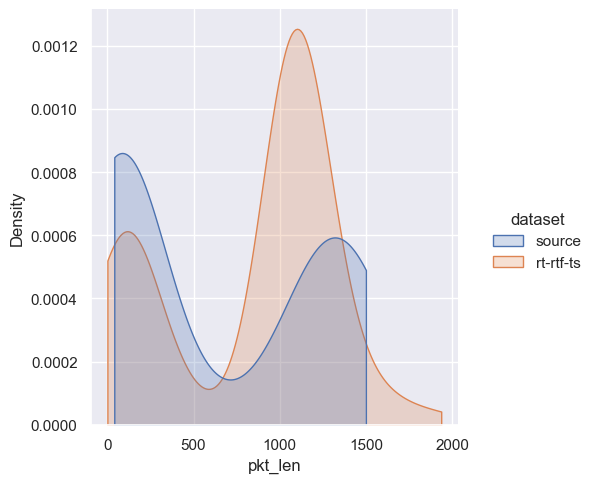

In [14]:
col = "pkt_len"
rf.labs.vis.plot_kde([source_data, syn_data], col)

**Categorical columns**


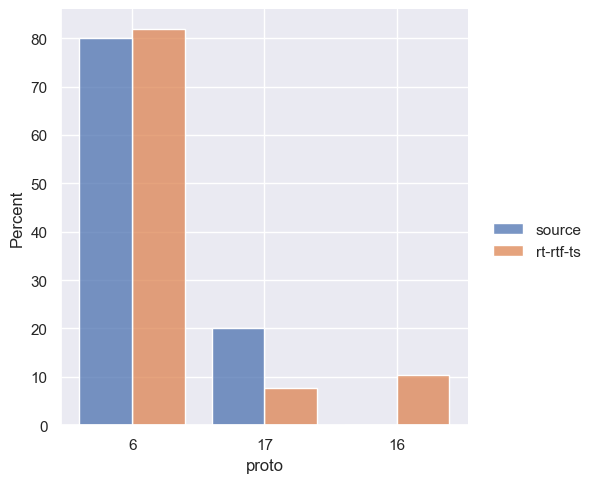

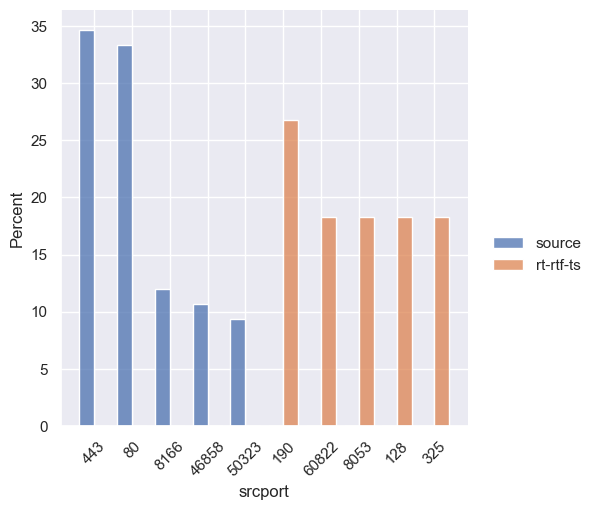

In [15]:
for col in ["proto", "srcport"]:
    source_agg = rf.metrics.count_all(source_data, col, nlargest=5)
    syn_agg = rf.metrics.count_all(syn_data, col, nlargest=5)
    rf.labs.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")